In [125]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from pricing.transformer import RareCategoryGrouper
from numpy import sqrt
from collections import defaultdict

In [75]:

def wykres_dla_modelu(y_pred_test, y_pred_train, title):
    
    print(f"RMSE - zbiór uczący: {sqrt(mean_squared_error(y_train, y_pred_train))}")
    print(f"R^2 - zbiór uczący: {r2_score(y_train, y_pred_train)}")
    print(f"RMSE - zbiór testowy: {sqrt(mean_squared_error(y_test, y_pred_test))}")
    print(f"R^2 - zbiór testowy: {r2_score(y_test, y_pred_test)}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_pred_train, color='red', edgecolor='black', alpha=0.2)
    plt.scatter(y_test, y_pred_test, color='deepskyblue', edgecolor='black', alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.grid(axis='x', linestyle=':', alpha=0.7)
    plt.xlabel("Rzeczywista cena")
    plt.ylabel("Przewidywana cena")
    plt.title(title)
    plt.show()
    
    

RMSE - zbiór uczący: 8875.939108179022
R^2 - zbiór uczący: 0.924478490405636
RMSE - zbiór testowy: 12492.392794382453
R^2 - zbiór testowy: 0.871435570388948


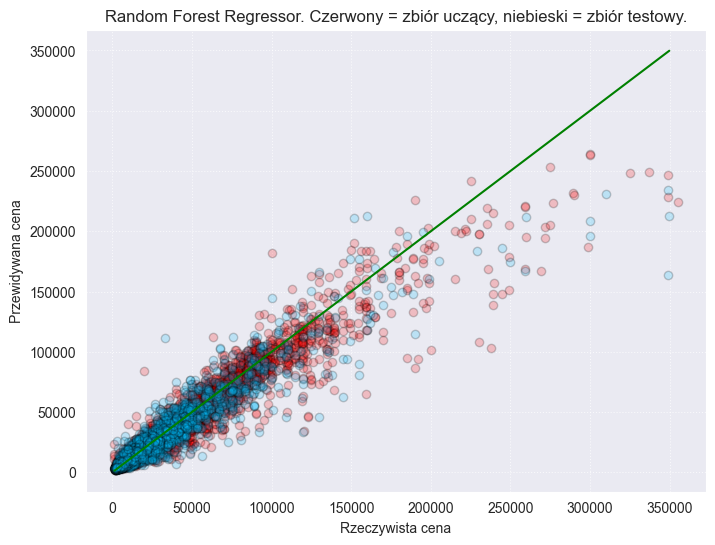

In [91]:
cat_cols = ['Model', 'Paliwo', 'Typ nadwozia', 'Kolor', 'Skrzynia biegów', 
            'Kraj pochodzenia', 'Napęd', 'Kierownica', 'Województwo', 
            'Rodzaj ogłoszenia', 'Producent']
preprocess = Pipeline([
    ('rare_producent', RareCategoryGrouper('Producent', min_count=10)),
    ('rare_kraj', RareCategoryGrouper('Kraj pochodzenia', min_count=15)),
    ('onehot', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('column_dropper', 'drop', "Przebieg")
        ],
        remainder='passthrough'
    )),
])
regressor = TransformedTargetRegressor(
    regressor=RandomForestRegressor(max_depth = 15, min_samples_leaf = 4, min_samples_split = 10, n_estimators =200), 
    func=np.log,
    inverse_func=np.exp
)
full_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('regressor', regressor)
])
df = pd.read_csv("../datasets/cars_cleaned.csv")    
x = df.drop(columns=["Cena"])
y = df["Cena"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
full_pipeline.fit(x_train, y_train)
y_pred_train = full_pipeline.predict(x_train)
y_pred_test = full_pipeline.predict(x_test)
wykres_dla_modelu(y_pred_test, y_pred_train, "Random Forest Regressor. Czerwony = zbiór uczący, niebieski = zbiór testowy.")



Model wykazuje przeuczenie, a w przypadku obu zbiorów istnieje lekka tendencja do zaniżania wyceny.

In [ ]:
full_pipeline.fit(x, y)
joblib.dump(full_pipeline, "model_pipeline.joblib")

Analiza modelu

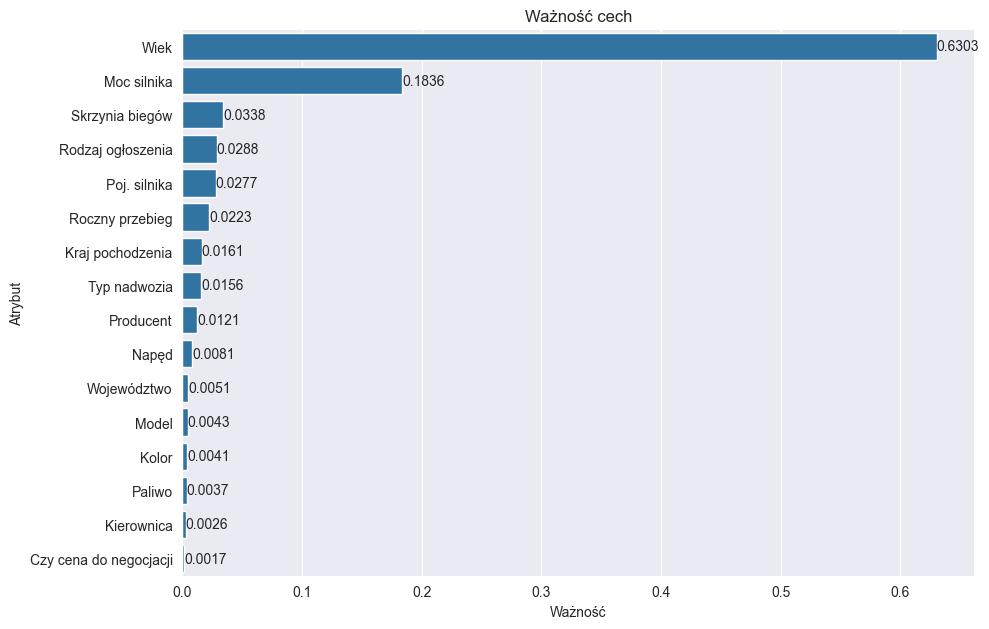

In [129]:
RFR = full_pipeline.named_steps['regressor'].regressor_
waznosci = RFR.feature_importances_

#odwracanie pipeline'u

enkoder = full_pipeline.named_steps['preprocess'].named_steps['onehot']
atrybuty_zakodowane = enkoder.named_transformers_['cat'].get_feature_names_out(cat_cols)
passthrough_cols = [col for col in x.columns if col not in cat_cols + ["Przebieg"]]
atrybuty = np.concatenate([atrybuty_zakodowane, passthrough_cols])

scalone_zmienne = {}
for atrybut in atrybuty:
    matched = False
    for cat in cat_cols:
        if atrybut.startswith(cat + '_'):
            scalone_zmienne[atrybut] = cat
            matched = True
            break
    if not matched:
        scalone_zmienne[atrybut] = atrybut  

fi_dict = defaultdict(float)
for nazwa, waznosc in zip(atrybuty, waznosci):
    oryginal = scalone_zmienne[nazwa]
    fi_dict[oryginal] += waznosc

fi_df = pd.DataFrame(fi_dict.items(),columns=["Atrybut", "Ważność"]).sort_values(by="Ważność", ascending=False)

plt.figure(figsize=(10, 0.4 * len(fi_df)))
plot = sns.barplot(data=fi_df, y="Atrybut", x="Ważność",  order=fi_df["Atrybut"])
plot.bar_label(plot.containers[0], fmt="%.4f")
plt.title("Ważność cech")
plt.tight_layout()
plt.show()

In [147]:
test_df = x_test.copy()
test_df["Rzeczywista cena"] = y_test
test_df["Przewidywana cena"] = y_pred_test
test_df["SE"] = (test_df["Przewidywana cena"] - test_df["Rzeczywista cena"]) ** 2
rmse_summary_dict = {}

for col in cat_cols:
    grouped = test_df.groupby(col).agg(
        RSME=("SE", lambda x: np.sqrt(np.mean(x))),
        count=("SE", "count"),
    ).sort_values("count", ascending=False)
    rmse_summary_dict[col] = grouped

for col in cat_cols:
    corr = rmse_summary_dict[col].corr().loc['RSME', 'count']
    print("Korelacja pomiędzy 'count' a 'RSME' dla atrybutu", col, ":" , round(corr, 2))
    print(rmse_summary_dict[col].head(20))
    print("=-"*25+"=")

Korelacja pomiędzy 'count' a 'RSME' dla atrybutu Model : -0.1
                  RSME  count
Model                        
A4         6952.564377     78
Seria 3    7486.027913     77
Astra      4702.099848     76
Passat     5128.886697     61
Golf       4922.344181     60
Seria 5   12668.720063     57
Focus      5700.590401     52
A3         7039.491866     52
A6        11084.392324     51
Corsa      3633.004209     36
Octavia    7051.207003     32
Fiesta     6501.120632     31
Megane     4479.352137     30
Insignia   6728.019480     29
Mondeo     5523.490970     28
Leon       5545.635749     23
Civic      4313.250037     23
Seria 1    5523.527639     23
Avensis    7073.960838     22
Touran     6944.566997     22
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Korelacja pomiędzy 'count' a 'RSME' dla atrybutu Paliwo : 1.0
                 RSME  count
Paliwo                      
Diesel   13155.452550   1131
Benzyna  12514.431419    961
LPG       8701.756728    246
=-=-=-=-=-=-=-=-=-=

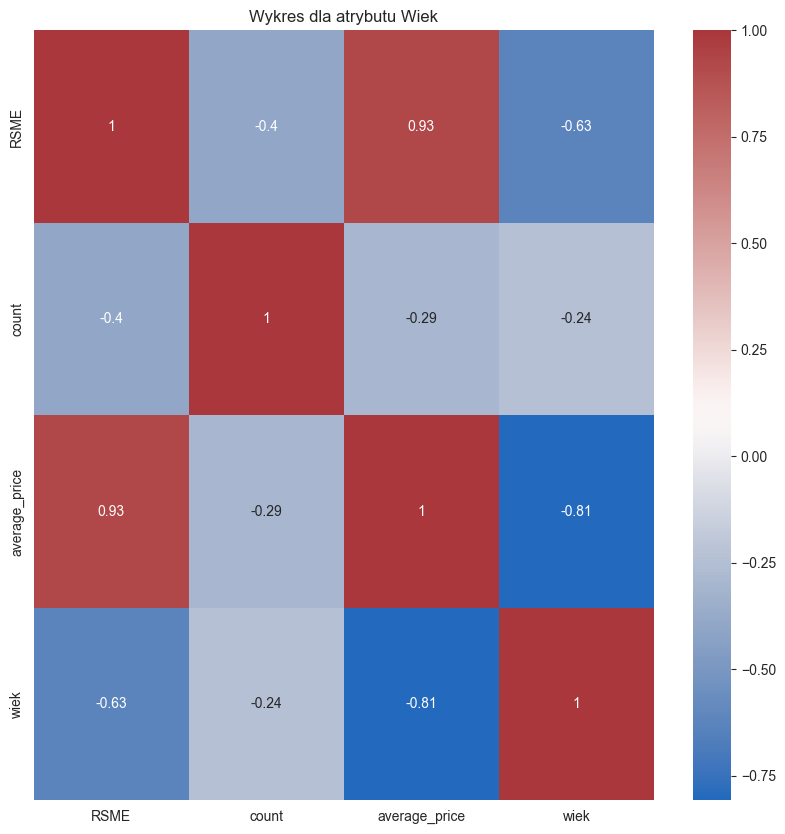

              RSME  count  average_price  wiek
Wiek                                          
1     42472.386808      4  142637.500000   1.0
2     25943.733009      3  126133.333333   2.0
3     54350.984415     15  162369.333333   3.0
4     26051.254407     18  105555.500000   4.0
5     24611.990276     27   96425.851852   5.0
6     33322.972210     59   90144.135593   6.0
7     15427.084718     72   76056.902778   7.0
8     21306.006311     92   66473.097826   8.0
9     14212.958614     97   56278.474227   9.0
10    12813.306283    106   44742.594340  10.0
11    14117.382160    121   41661.438017  11.0
12    13528.928393     84   36357.464286  12.0
13    13570.942291    113   31901.867257  13.0
14     7813.265998    140   25134.435714  14.0
15     6734.139770    168   22029.982143  15.0
16     5869.896802    170   18167.758765  16.0
17     6295.522263    150   16997.740000  17.0
18     5678.286634    179   13882.569832  18.0
19     5009.685251    165   12133.987879  19.0
20     4734.2

In [149]:
col = "Wiek"
grouped = test_df.groupby(col).agg(RSME=("SE", lambda x: np.sqrt(np.mean(x))),count=("SE", "count"),
                                   average_price=("Rzeczywista cena", "mean"),#std_price=("Rzeczywista cena", "std"),
                                   wiek=(col, "mean")).sort_values("count", ascending=False)
#grouped["ratio"] = grouped["std_price"] / grouped["average_price"]
rmse_summary_dict[col] = grouped
plt.figure(figsize=(10, 10))
heatmap = rmse_summary_dict[col][['RSME', 'count', 'average_price', "wiek"]] #, 'ratio'
sns.heatmap(heatmap.corr(), annot=True, cmap="vlag")
plt.title("Wykres dla atrybutu " + col)
plt.show()
print(rmse_summary_dict[col].sort_values('wiek').head(40))